<a href="https://colab.research.google.com/github/beepmo/gator/blob/main/data/06-20/litao3_gating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install impedance -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 439.8 kB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from google.colab import userdata
import plotly.express as px
from impedance import preprocessing
from impedance.models.circuits import CustomCircuit

In [ ]:
!git config --global user.email {userdata.get('email')}
!git config --global user.name {userdata.get('name')}
!git clone https://{userdata.get('token')}@github.com/beepmo/gator
%pwd

Cloning into 'gator'...
remote: Enumerating objects: 881, done.
remote: Counting objects: 100% (171/171), done.
remote: Compressing objects: 100% (152/152), done.
remote: Total 881 (delta 110), reused 25 (delta 18), pack-reused 710
Receiving objects: 100% (881/881), 46.34 MiB | 9.20 MiB/s, done.
Resolving deltas: 100% (479/479), done.
Updating files: 100% (116/116), done.


'/content'

In [ ]:
%cd "/content/gator/data/06-20/"

/content/gator/data/06-20


# 20-06-24 LiTaO3 gating

First part : measurement of the current without any gating nor liquid

Seconde part : Adding IL without gating

Then gating, electrode on, no gating voltage

Finally : gating
- Frequency : 0.1 Hz
- Amplitude : 1 Vpp
- Offset : 870 mV
- Duty Cycle : 75%







# Base Time
06/20/2024 12:42:09

In [ ]:
# prompt: delete first 8 lines from full_buffer.csv

def prep_csv(filename):

  # Read the full buffer into a list of lines
  with open(filename, 'r') as f:
    lines = f.readlines()

  # print base time
  print(lines[2])

  # Delete the first 8 lines
  lines = lines[8:]

  # Write the remaining lines back to the file
  with open(filename, 'w') as f:
    f.writelines(lines)

In [ ]:
prep_csv('defbuffer1_0620_124209.csv')
df = pd.read_csv('defbuffer1_0620_124209.csv')


Fill Mode,1



In [ ]:
df

Reading    Unit  Range Digits  Disp Digits Math Start Group  \
0      1.011751e-10  Amp DC  1.000000e-08          5.5    F           F   
1      9.315581e-11  Amp DC  1.000000e-08          5.5    F           F   
2      1.169240e-10  Amp DC  1.000000e-07          5.5    F           F   
3      1.105656e-10  Amp DC  1.000000e-08          5.5    F           F   
4      1.145614e-10  Amp DC  1.000000e-08          5.5    F           F   
...             ...     ...           ...          ...  ...         ...   
34738 -4.314186e-06  Amp DC  1.000000e-05          5.5    F           F   
34739 -4.305924e-06  Amp DC  1.000000e-05          5.5    F           F   
34740 -4.301185e-06  Amp DC  1.000000e-05          5.5    F           F   
34741 -4.295412e-06  Amp DC  1.000000e-05          5.5    F           F   
34742 -4.291543e-06  Amp DC  1.000000e-05          5.5    F           F   

      Limit1 High Limit1 Low Limit2 High Limit2 Low  ... Questionable Origin  \
0               F          F           F          F  ...            F   Main   
1               F          F           F          F  ...            F   Main   
2               F          F           F          F  ...            F   Main   
3               F          F           F          F  ...            F   Main   
4               F          F           F          F  ...            F   Main   
...           ...        ...         ...        ...  ...          ...    ...   
34738           F          F           F          F  ...            F   Main   
34739           F          F           F          F  ...            F   Main   
34740           F          F           F          F  ...            F   Main   
34741           F          F           F          F  ...            F   Main   
34742           F          F           F          F  ...            F   Main   

          Value   Unit.1 Digits  Output Sense Source Limit Overtemp  \
0      0.995772  Volt DC      1       T    2W            F        F   
1      0.995812  Volt DC      1       T    2W            F        F   
2      0.999987  Volt DC      1       T    2W            F        F   
3      0.995993  Volt DC      1       T    2W            F        F   
4      0.995851  Volt DC      1       T    2W            F        F   
...         ...      ...    ...     ...   ...          ...      ...   
34738  0.999997  Volt DC      1       T    2W            F        F   
34739  0.999998  Volt DC      1       T    2W            F        F   
34740  0.999997  Volt DC      1       T    2W            F        F   
34741  0.999997  Volt DC      1       T    2W            F        F   
34742  0.999995  Volt DC      1       T    2W            F        F   

      Relative Time  
0          0.000000  
1          0.069395  
2          0.618785  
3          0.860499  
4          0.929883  
...             ...  
34738   5498.177418  
34739   5498.246757  
34740   5498.316085  
34741   5498.385422  
34742   5498.454741  

[34743 rows x 21 columns]

In [ ]:
# Time (s)
T = df['Relative Time']

# Current (mA)
I = df['Reading'] * 1e9

# Potential (mV)
V = df['Value'] * 1e3

Text(0.5, 0, 'Time (s)')

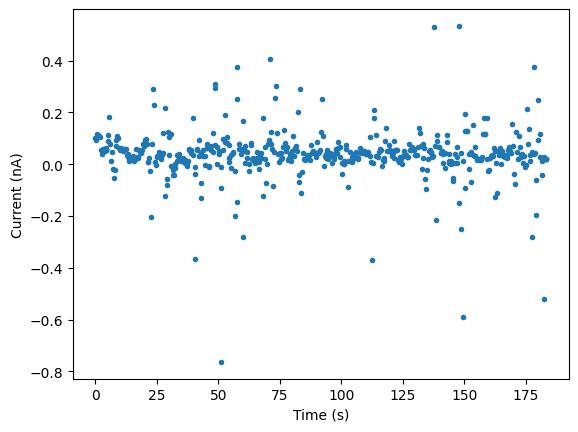

In [ ]:
cut1 = 0
cut2 = 509
plt.plot(T[cut1:cut2],I[cut1:cut2],'.')
plt.ylabel('Current (nA)')
plt.xlabel('Time (s)')

# Adding a drop of IL

Signal is smoothed without increase in conductivity. We suspect this is due to ionic liquid shielding static charges.

In the smoothed signal, we identify a signal with 10s period and 50% duty cycle. This corresponds to the square wave being output on the Keysight signal generator. Its output is connected to the PCB (`GND` and `GATE`). A copper strip goes off one side of the `GATE` pad but no LMO electrode is connected.

Possible reasons for the `GATE` signal to show up in src-drn current:
- `GND` is shifted by the Keysight generator signal.
- Asymmetric voltage (through the resisting PCB) biases the SRC vs DRN voltage.

Text(0.5, 0, 'Time (s)')

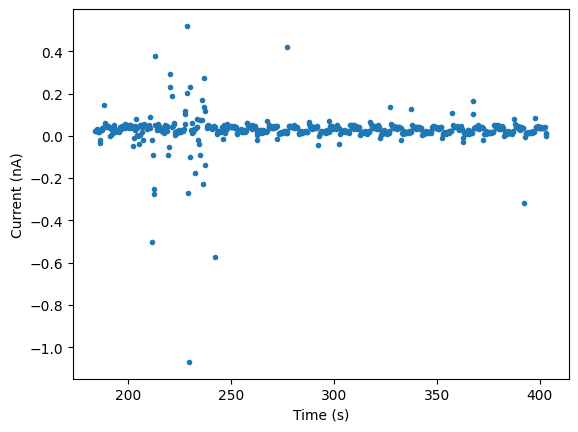

In [ ]:
# We can see the adding of IL

cut1 = 510
cut2 = 1131
plt.plot(T[cut1:cut2],I[cut1:cut2],'.')
plt.ylabel('Current (nA)')
plt.xlabel('Time (s)')

# Installed gate, but touched DRN-SRC wires together

Keithley limit 0.1mA is visible haha

After the incident (first contact with LMO electrode?) drn-src current jumped from 1nA to 500nA.

Text(0.5, 0, 'Time (s)')

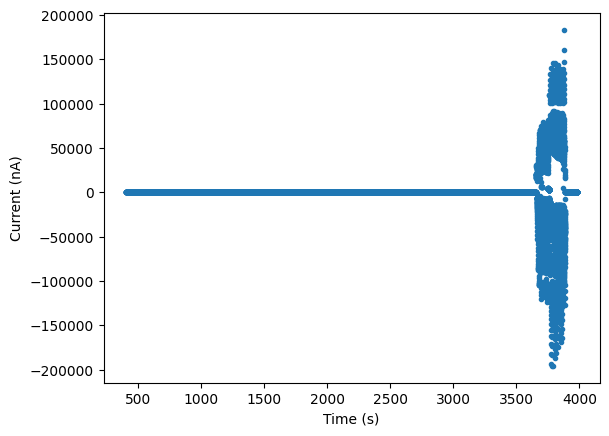

In [ ]:
# Fixed voltage and beginning of gating, but with short cut

cut1 = 1132
cut2 = 14000
plt.plot(T[cut1:cut2],I[cut1:cut2],'.')
plt.ylabel('Current (nA)')
plt.xlabel('Time (s)')

# Actual gating
In between the gating, we changed the gating electrode placement, to obtain a stable open circuit voltage.

In `px` plot it is clear that each gating attempt increases conductivity.

Text(0.5, 0, 'Time (s)')

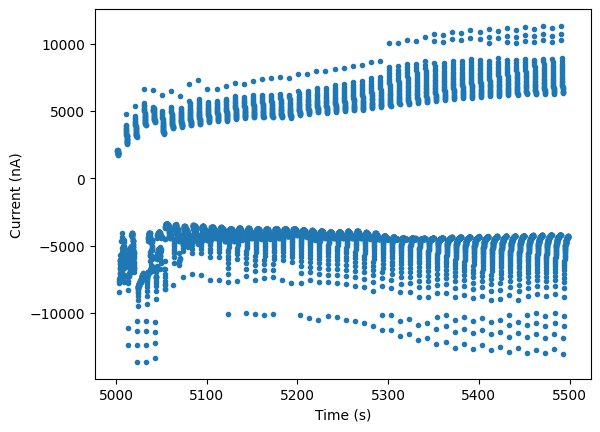

In [ ]:
# Gating

cut1 = 28678
cut2 = len(T)
plt.plot(T[cut1:cut2],I[cut1:cut2],'.')
plt.ylabel('Current (nA)')
plt.xlabel('Time (s)')

Increase in conductivity with every gating cycle

Text(0.5, 0, 'Time (s)')

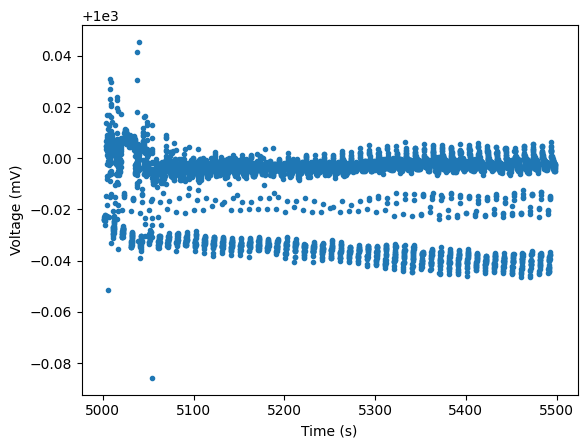

In [ ]:
cut1 = 28678
cut2 = len(T)
plt.plot(T[cut1:cut2],V[cut1:cut2],'.')
plt.ylabel('Voltage (mV)')
plt.xlabel('Time (s)')

In [ ]:
df_new = df[['Relative Time', 'Value', 'Reading']]
df_new.loc[:, 'Reading'] = df_new['Reading'] * 1e9
df_new.loc[:, 'Value'] = df_new['Value'] * 100
df_new.rename(columns={'Reading': 'Current (nA)', 'Value': 'Vds (1e-2 V)'}, inplace=True)

<ipython-input-14-e44d9732e7c6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.rename(columns={'Reading': 'Current (nA)', 'Value': 'Vds (1e-2 V)'}, inplace=True)


In [ ]:
# prompt: generately plotly express scatter plots of current and voltage over time from df_new

# fig = px.scatter(df_new, x="Relative Time", y=["Current (nA)", "Vds (1e-2 V)"])
fig = px.scatter(df_new, x="Relative Time", y=["Current (nA)"])
fig.show()

In [ ]:
df_new = df[['Relative Time', 'Value', 'Reading']]
df_new.loc[:, 'Reading'] = df_new['Reading'] * 1e9
df_new.loc[:, 'Value'] = df_new['Value'] * 100
df_new.rename(columns={'Reading': 'Current (nA)', 'Value': 'Vds (1e-2 V)'}, inplace=True)

<ipython-input-16-e44d9732e7c6>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# prompt: generately plotly express scatter plots of current and voltage over time from df_new

# fig = px.scatter(df_new, x="Relative Time", y=["Current (nA)", "Vds (1e-2 V)"])
fig = px.scatter(df_new, x="Relative Time", y=["Vds (1e-2 V)"])
fig.show()

# EIS on gated sample



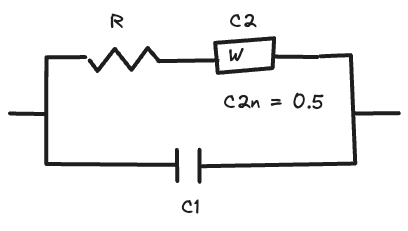

## High to low sweep

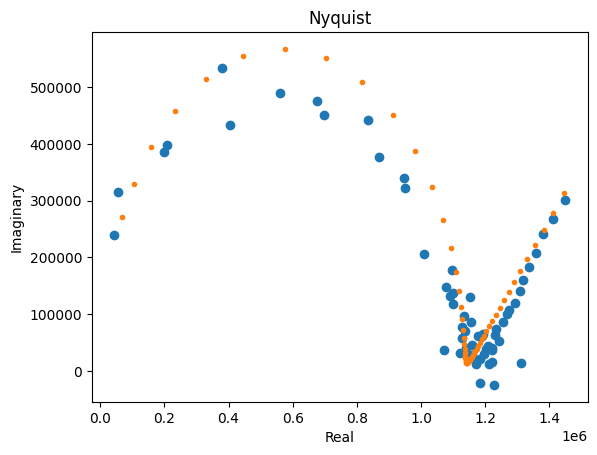

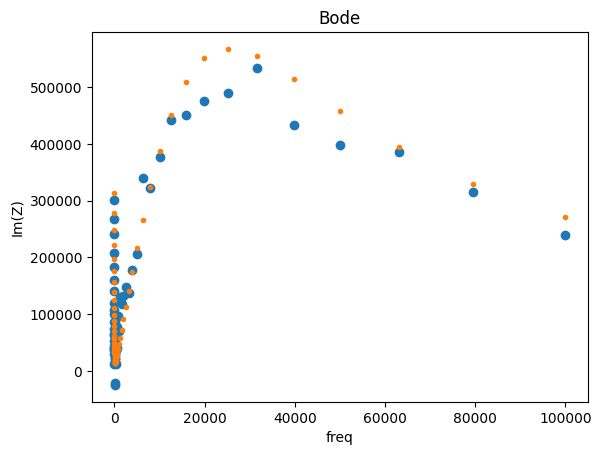

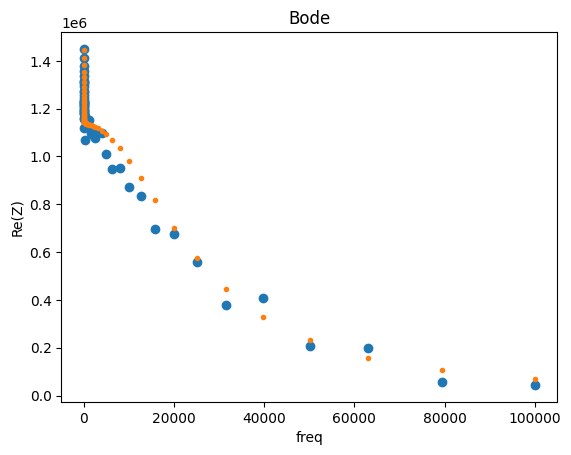

In [ ]:
freqs, Z = preprocessing.readZPlot('LiTao3_htol.z')
freqs, Z = np.delete(freqs, 32), np.delete(Z, 32) # remove 1 noise point (argmin(Z.imag))

circuit = 'p(R0-W0,C0)'
init = [10**6, 10**-7, 10**-8]

circuit = CustomCircuit(circuit, initial_guess=init)
circuit.fit(freqs, Z)
Z_fit = circuit.predict(freqs)

plt.plot(Z.real, -Z.imag, 'o')
plt.plot(Z_fit.real, -Z_fit.imag, '.')
plt.ylabel('Imaginary')
plt.xlabel('Real')
plt.title('Nyquist')
plt.show()

plt.plot(freqs, -Z.imag, 'o')
plt.plot(freqs, -Z_fit.imag, '.')
plt.ylabel('Im(Z)')
plt.xlabel('freq')
plt.title('Bode')
plt.show()

plt.plot(freqs, Z.real, 'o')
plt.plot(freqs, Z_fit.real, '.')
plt.ylabel('Re(Z)')
plt.xlabel('freq')
plt.title('Bode')
plt.show()

In [ ]:
print(circuit)


Circuit string: p(R0-W0,C0)
Fit: True

Initial guesses:
     R0 = 1.00e+06 [Ohm]
     W0 = 1.00e-07 [Ohm sec^-1/2]
     C0 = 1.00e-08 [F]

Fit parameters:
     R0 = 1.13e+06  (+/- 2.04e-24) [Ohm]
     W0 = 2.48e+05  (+/- 4.71e-25) [Ohm sec^-1/2]
     C0 = 5.51e-12  (+/- 9.63e-11) [F]



## Low to high sweep

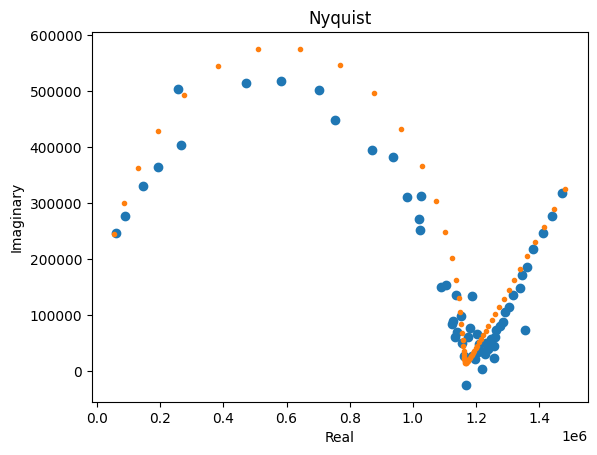

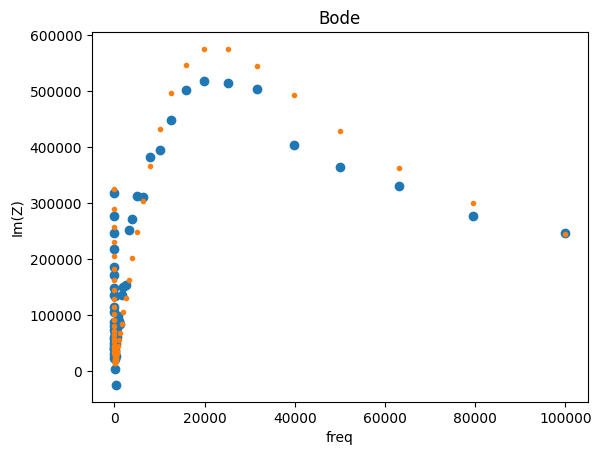

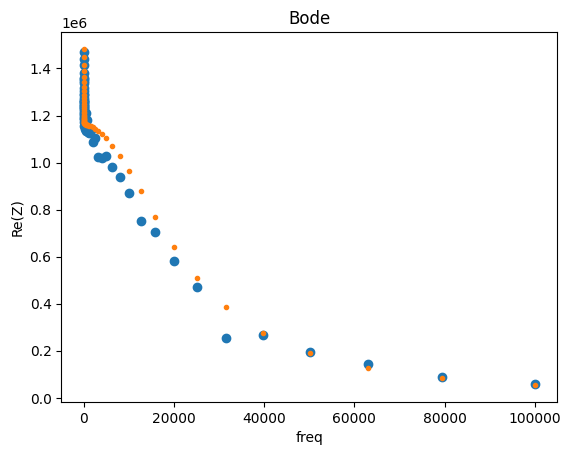

In [ ]:
freqs, Z = preprocessing.readZPlot('LiTao3_ltoh.z')
freqs, Z = np.delete(freqs, 28), np.delete(Z, 28) # remove 1 noise point (argmin(Z.imag))

circuit = 'p(R0-W0,C0)'
init = [10**6, 10**-7, 10**-8]

circuit = CustomCircuit(circuit, initial_guess=init)
circuit.fit(freqs, Z)
Z_fit = circuit.predict(freqs)

plt.plot(Z.real, -Z.imag, 'o')
plt.plot(Z_fit.real, -Z_fit.imag, '.')
plt.ylabel('Imaginary')
plt.xlabel('Real')
plt.title('Nyquist')
plt.show()

plt.plot(freqs, -Z.imag, 'o')
plt.plot(freqs, -Z_fit.imag, '.')
plt.ylabel('Im(Z)')
plt.xlabel('freq')
plt.title('Bode')
plt.show()

plt.plot(freqs, Z.real, 'o')
plt.plot(freqs, Z_fit.real, '.')
plt.ylabel('Re(Z)')
plt.xlabel('freq')
plt.title('Bode')
plt.show()

In [ ]:
print(circuit)


Circuit string: p(R0-W0,C0)
Fit: True

Initial guesses:
     R0 = 1.00e+06 [Ohm]
     W0 = 1.00e-07 [Ohm sec^-1/2]
     C0 = 1.00e-08 [F]

Fit parameters:
     R0 = 1.16e+06  (+/- 2.17e-24) [Ohm]
     W0 = 2.58e+05  (+/- 4.88e-25) [Ohm sec^-1/2]
     C0 = 6.17e-12  (+/- 1.05e-10) [F]



# Add resistors for ionic (gets warburg), electronic in parallel

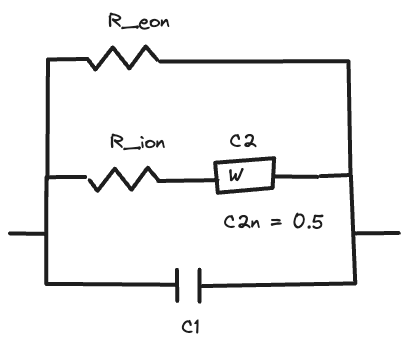

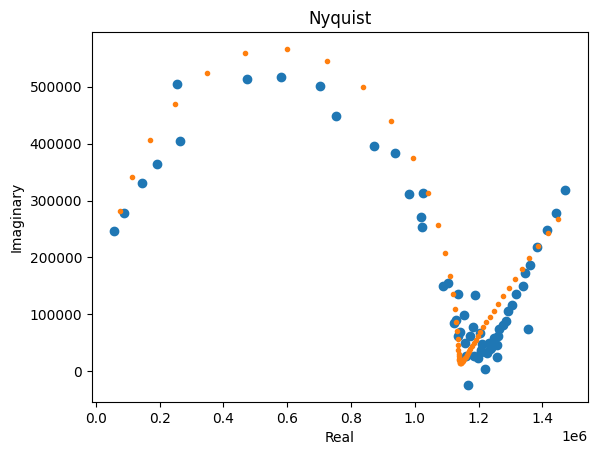

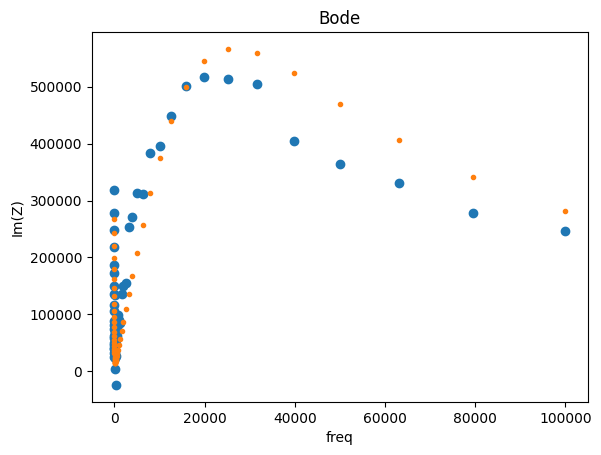

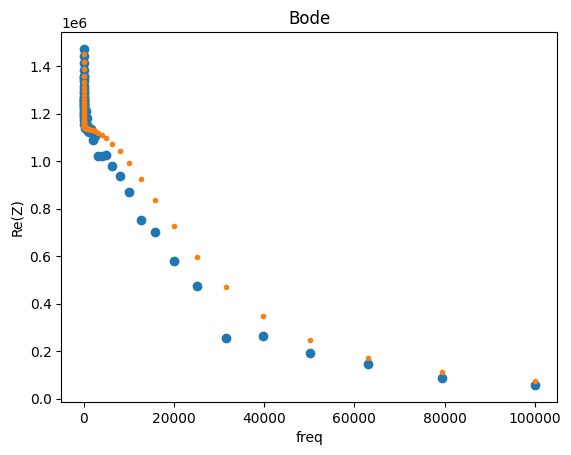

In [ ]:
freqs, Z = preprocessing.readZPlot('LiTao3_ltoh.z')
freqs, Z = np.delete(freqs, 28), np.delete(Z, 28) # remove 1 noise point (argmin(Z.imag))

circuit = 'p(p(R0-W0,R1),C0)'
init = [10**6, 10**4, 10**9, 10**-12]

circuit = CustomCircuit(circuit, initial_guess=init)
circuit.fit(freqs, Z)
Z_fit = circuit.predict(freqs)

plt.plot(Z.real, -Z.imag, 'o')
plt.plot(Z_fit.real, -Z_fit.imag, '.')
plt.ylabel('Imaginary')
plt.xlabel('Real')
plt.title('Nyquist')
plt.show()

plt.plot(freqs, -Z.imag, 'o')
plt.plot(freqs, -Z_fit.imag, '.')
plt.ylabel('Im(Z)')
plt.xlabel('freq')
plt.title('Bode')
plt.show()

plt.plot(freqs, Z.real, 'o')
plt.plot(freqs, Z_fit.real, '.')
plt.ylabel('Re(Z)')
plt.xlabel('freq')
plt.title('Bode')
plt.show()

In [ ]:
print(circuit)


Circuit string: p(p(R0-W0,R1),C0)
Fit: True

Initial guesses:
     R0 = 1.00e+06 [Ohm]
     W0 = 1.00e+04 [Ohm sec^-1/2]
     R1 = 1.00e+09 [Ohm]
     C0 = 1.00e-12 [F]

Fit parameters:
     R0 = 1.49e+06  (+/- 1.65e-24) [Ohm]
     W0 = 4.41e+05  (+/- 3.20e-25) [Ohm sec^-1/2]
     R1 = 4.70e+06  (+/- 1.86e-25) [Ohm]
     C0 = 5.28e-12  (+/- 1.44e-10) [F]



# Make depressed semicircle
Problem: least squares tends to decrease CPE $n$ too much.

`xtol` termination condition is satisfied.
Function evaluations 53, initial cost 3.9260e+13, final cost 6.3959e+11, first-order optimality 9.87e+19.


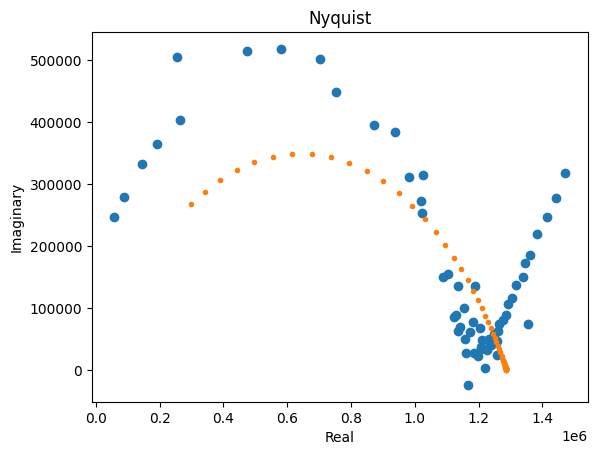

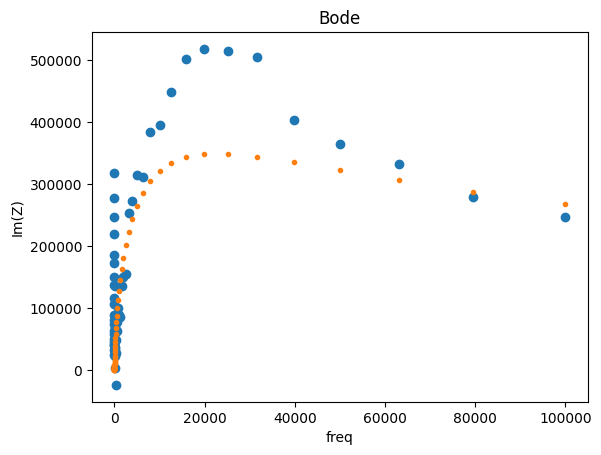

In [ ]:
freqs, Z = preprocessing.readZPlot('LiTao3_ltoh.z')
freqs, Z = np.delete(freqs, 28), np.delete(Z, 28) # remove 1 noise point (argmin(Z.imag))

circuit = 'p(p(R0-W0,R1),CPE0)'
init = [1.24*10**6, 2.45*10**5, 3.25*10**7, 6.65*10**-1, 1]

circuit = CustomCircuit(circuit, initial_guess=init)
circuit.fit(freqs, Z, verbose=True)
Z_fit = circuit.predict(freqs)

plt.plot(Z.real, -Z.imag, 'o')
plt.plot(Z_fit.real, -Z_fit.imag, '.')
plt.ylabel('Imaginary')
plt.xlabel('Real')
plt.title('Nyquist')
plt.show()

plt.plot(freqs, -Z.imag, 'o')
plt.plot(freqs, -Z_fit.imag, '.')
plt.ylabel('Im(Z)')
plt.xlabel('freq')
plt.title('Bode')
plt.show()

# Constant current polarization

A constant current is set to 1µA (measured 0.925-0.95µA). Voltage measured across the sample increases exponentially, from 1.5V to 3.5V.

The mixed conductor model (Maier p445-454) tells us
$$
U=IR_{eon}\left( 1-\frac{R_{\text{eon}}}{R_{\text{eon}}+R_{\text{ion}}}\exp\left( -\frac{t}{\tau} \right) \right)
$$
where
$$
\tau=(R_{\text{eon}}+R_{\text{ion}})C^{\delta}.
$$

Maier explains how the diffusion coefficient $D$ is given by $\tau$,
$$
D^{\delta}=\frac{4L^2}{\pi  ^{2}\tau }.
$$

We have $\log(U(\infty)-U(t))$ linear in $t$ and fit to obtain $\tau^{-1}=3.75\cdot 10^{-4} \mathrm{\frac{1}{s}}$. Lower bounding $L\geq 1\cdot 10^{-3}\text{ m}$, we find
$$
D^{\delta}\geq 1\cdot 10^{-10} \mathrm{\frac{m^{2}}{s}}.
$$
This is huge! Let's bug shoot. The most pertinent bug lies in assuming homogeneous lateral planes when we introduce $L$.

In [ ]:
prep_csv('polarization.csv')

Fill Mode,0



In [ ]:
df = pd.read_csv('polarization.csv')

In [ ]:
df

Reading     Unit  Range Digits  Disp Digits Math Start Group  \
0      0.000003  Volt DC          0.01          5.5    F           F   
1      0.000003  Volt DC          0.01          5.5    F           F   
2      0.000003  Volt DC          0.01          5.5    F           F   
3      0.000003  Volt DC          0.01          5.5    F           F   
4      0.000003  Volt DC          0.01          5.5    F           F   
...         ...      ...           ...          ...  ...         ...   
99995  3.460760  Volt DC         10.00          5.5    F           F   
99996  3.462924  Volt DC         10.00          5.5    F           F   
99997  3.462897  Volt DC         10.00          5.5    F           F   
99998  3.461302  Volt DC         10.00          5.5    F           F   
99999  3.463063  Volt DC         10.00          5.5    F           F   

      Limit1 High Limit1 Low Limit2 High Limit2 Low  ... Questionable Origin  \
0               F          F           F          F  ...            F   Main   
1               F          F           F          F  ...            F   Main   
2               F          F           F          F  ...            F   Main   
3               F          F           F          F  ...            F   Main   
4               F          F           F          F  ...            F   Main   
...           ...        ...         ...        ...  ...          ...    ...   
99995           F          F           F          F  ...            F   Main   
99996           F          F           F          F  ...            F   Main   
99997           F          F           F          F  ...            F   Main   
99998           F          F           F          F  ...            F   Main   
99999           F          F           F          F  ...            F   Main   

              Value  Unit.1 Digits  Output Sense Source Limit Overtemp  \
0      4.422340e-08  Amp DC   0.01       F    2W            F        F   
1      4.213710e-08  Amp DC   0.01       F    2W            F        F   
2      3.726910e-08  Amp DC   0.01       F    2W            F        F   
3      3.796450e-08  Amp DC   0.01       F    2W            F        F   
4      4.352800e-08  Amp DC   0.01       F    2W            F        F   
...             ...     ...    ...     ...   ...          ...      ...   
99995  9.266932e-07  Amp DC   0.01       T    2W            F        F   
99996  9.266931e-07  Amp DC   0.01       T    2W            F        F   
99997  9.273884e-07  Amp DC   0.01       T    2W            F        F   
99998  9.273884e-07  Amp DC   0.01       T    2W            F        F   
99999  9.273879e-07  Amp DC   0.01       T    2W            F        F   

      Relative Time  
0          0.000000  
1          0.069373  
2          0.138707  
3          0.208057  
4          0.277421  
...             ...  
99995   6934.067718  
99996   6934.137046  
99997   6934.206385  
99998   6934.275700  
99999   6934.345017  

[100000 rows x 21 columns]

In [ ]:
# Time (s)
T = df['Relative Time']

# Current (mA)
I = df['Value'] * 1e9

# Potential (mV)
V = df['Reading'] * 1e3

(800.0, 995.2952950000001)

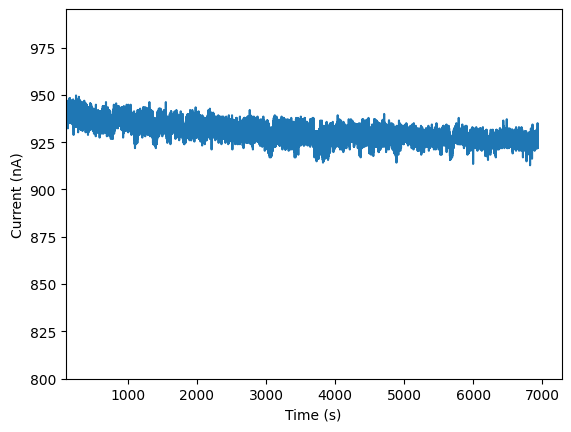

In [ ]:
plt.plot(T, I)
plt.ylabel('Current (nA)')
plt.xlabel('Time (s)')
plt.xlim(100)
plt.ylim(800)

In [ ]:
df_new = df[['Relative Time', 'Value', 'Reading']]
df_new.loc[:, 'Reading'] = df_new['Reading'] * 1e9
df_new.loc[:, 'Value'] = df_new['Value'] * 100
df_new.rename(columns={'Reading': 'Current (nA)', 'Value': 'Vds (1e-2 V)'}, inplace=True)

<ipython-input-28-e44d9732e7c6>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
fig = px.scatter(df, x="Relative Time", y=["Reading"])
fig.show()


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning:

invalid value encountered in log



Text(0.5, 0, 'Time (s)')

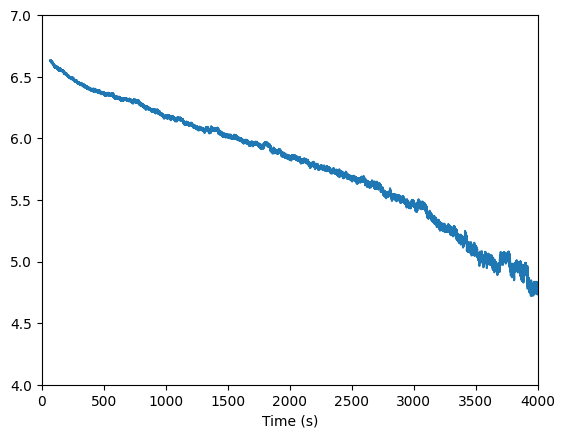

In [ ]:
c1 = 1000
plt.plot(T[c1:],np.log(V[len(T)-1] * np.ones_like(T) - V)[c1:])
plt.xlim(0,4000)
plt.ylim(4,7)
plt.xlabel('Time (s)')

In [ ]:
-1.5/4000

-0.000375